<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/statistics/stock-price-pred/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import yfinance as yf

In [3]:
data = yf.download(tickers='TSLA', period='24mo', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-06,67.000000,67.772003,66.954002,67.178001,67.178001,38062000
2019-12-09,67.318001,68.889999,67.015999,67.905998,67.905998,45115500
2019-12-10,67.991997,70.146004,67.862000,69.767998,69.767998,44141500
2019-12-11,70.375999,71.438004,70.218002,70.540001,70.540001,34489000
2019-12-12,70.984001,72.547997,70.646004,71.935997,71.935997,38819500


In [5]:
cols = [ "Date", "Close", "Volume" ]
tsla_data = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/statistics/stock-price-pred/res/tsla_2yr_data.csv", usecols=cols)
tsla_data.head()

,Date,Close,Volume
0,2019-11-25,67.267998,61697500
1,2019-11-26,65.783997,39737000
2,2019-11-27,66.258003,27778000
3,2019-11-29,65.987999,12328000
4,2019-12-02,66.973999,30372500


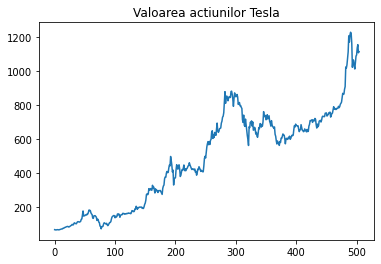

In [6]:
plt.title("Valoarea actiunilor Tesla")
plt.plot(tsla_data.Close)

In [7]:
max = tsla_data.Close.max()
real = pd.DataFrame({'value': tsla_data.Close / max})

In [8]:
real.head()

,value
0,0.054693
1,0.053487
2,0.053872
3,0.053653
4,0.054454


In [9]:
class Errors():
    '''
    Ex. Residual.Residual(real_data, forcast_data)
        MAD.MAD(real_data, forcast_data)
        MSE.MSE(real_data, forcast_data)
        MAPE.MAPE(real_data, forcast_data)
    '''
    @staticmethod
    def Residual(real_data, forcast_data):
        error = real_data - forcast_data
        error.dropna(inplace=True)
        return error
    
    @staticmethod
    def MAD(real_data, forcast_data):
        error = Errors.Residual(real_data, forcast_data)
        abs_err = abs(error)
        return np.average(abs_err)

    @staticmethod
    def MSE(real_data, forcast_data):
        error = Errors.Residual(real_data, forcast_data)
        sq_err = error ** 2
        return np.average(sq_err)
    
    @staticmethod
    def MAPE(real_data, forcast_data):
        error = Errors.Residual(real_data, forcast_data)
        abs_err = abs(error)
        abs_pr_err = abs_err / real_data
        abs_pr_err.dropna(inplace=True)
        mape = np.average(abs_pr_err)

In [10]:
class MovingAverage():
    '''
    Ex. MovingAverage.forcast(data, n)
        MovingAverage.solve(data, Errors.MAD, rng=[2,3,4])
    '''
    @staticmethod
    def forcast(data, n):
        l = len(data)

        res = pd.DataFrame(data={'val': np.zeros(l - n + 1)}, index=[i for i in range(n, l + 1)])
        res.val = [ np.sum(data[i-n:i]).val / n for i in range(n, len(data) + 1) ]

        return res
    
    @staticmethod
    def solve(data, err_f, rng=[2, 3]):
        min = 999999999999
        min_n = 999999999999

        for i in rng:
            val = err_f(data, MovingAverage.forcast(data, i))
            if val < min:
                min = val
                min_n = i
            
        return (min_n, min)

In [11]:
class WeightedMovingAverage():
    '''
    Ex. WeightedMovingAverage.forcast(data, weights=[.2, .8])
        WeightedMovingAverage.solve(a, Errors.MAD, nr_w=2, acc=2)
    '''

    @staticmethod
    def forcast(data, weights):
        if sum(weights) < 0 or sum(weights) > 1:
            raise NameError('Weights sum not in [0, 1] range')

        n = len(weights)
        l = len(data)

        res = pd.DataFrame(data={'val': np.zeros(l - n + 1)}, index=[i for i in range(n, l + 1)])
        res.val = [ np.sum(data[i-n:i].val * weights[::-1]) for i in range(n, len(data) + 1) ]

        return res


    @staticmethod
    def solve(data, err_f, nr_w=2, acc=2):
        s = 1 / (10 ** acc)
        comb = [*itertools.product([ i for i in np.arange(0, 1, s) ], repeat=nr_w)]
        filt_comb = filter(lambda x: np.sum(x) == 1, comb)
        min = 999999999999
        min_comb = ()
        
        for i in filt_comb:
            # print([*i])
            val = err_f(data, WeightedMovingAverage.forcast(data, [*i]))
            if val < min:
                min = val
                min_comb = i
            
        return (min_comb, min)

In [12]:
class ExponentialSmoothing():
    '''
    Ex. ExponentialSmoothing.forcast(data, alpha)
        ExponentialSmoothing.solve(data, Errors.MAD, acc=3)
    '''

    @staticmethod
    def forcast(data, alpha):
        l = len(data)
        res = pd.DataFrame(data={'val': np.zeros(l + 1)})
        res.val[0] = data.val[0]

        for i in range(l):
            res.val[i + 1] = (alpha*data.val[i]) + ((1-alpha)*res.val[i])

        return res


    @staticmethod
    def solve(data, err_f, acc=2):
        s = 1 / (10 ** acc)
        min = 999999999999

        for i in np.arange(0, 1, s):
            val = err_f(data, ExponentialSmoothing.forcast(data, i))
            if val < min:
                min = val
            
        return min

In [13]:

# plt.plot(err.index, err, label = "Error", linewidth=2)

In [14]:
# plt.figure(figsize=(20,10))
# plt.plot(real.index, real, label = "True", linewidth=2)
# plt.plot(ma2.index, ma2, label = "MA2", linewidth=2, alpha=0.7)
# plt.plot(ma3.index, ma3, label = "MA3", linewidth=2, alpha=0.7)
# plt.legend()
# plt.show()